## ![CESI](./photo_livrable/Logo_cesi.png)

# Projet Leyenda
## Livrable 2 - Traitement d'images
|Auteurs|
|---|
|Karim Salhi
|Corentin Devrouete
|Hugo Larose
|Pierre-Alain Tietz

L'objectif de ce livrable est de débruiter un ensemble de photographies.
### Importation des librairies,
Dans un premier temps nous allons importer toutes les libraires nécessaire à notre débruitage :
- **Keras**, la bibliothèque Keras permet d'interagir avec les algorithmes de réseaux de neurones profonds et d'apprentissage automatique, notamment Tensorflow.
- **Tensorflow**, TensorFlow est un outil open source d'apprentissage automatique développé par Google.
- **Numpy**, NumPy est une bibliothèque pour langage de programmation Python, destinée à manipuler des matrices ou tableaux multidimensionnels ainsi que des fonctions mathématiques opérant sur ces tableaux.
- **Matplotlib**, est une bibliothèque utilisée pour tracer et visualiser des données à l'aide de graphiques.
- **Scikit-Learn**, est une bibliothèque utilisée pour l'apprentissage automatique et l'analyse de métriques
- **OpenCV** est une bibliothèque utilisée pour du traitement d'images.
- **Tqdm** est une bibliothèque utilisée pour visualiser des progress bar configurables"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import pathlib
import os, cv2
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.models import Model
import keras.models as models
import keras.layers as layers
from keras.initializers import orthogonal

from skimage.util import random_noise
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

### Utilisation du GPU


Dans l'optique d’avoir de meilleures performances tout au long de ce projet notamment durant l’entraînement du modèle, nous avons décidé de faire passer le traitement des données par le GPU. Pour ce faire, la ligne ci-dessous nous indique si le système détecte un GPU qui peut être utilisé. (Seules les cartes Nvdia, avec Cuda installé, sont reconnues par Tensorflow).

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

### Initialisation des hyperparamètres

Ces paramètres nous servirons tout au long de notre programme d'intelligence artificielle :
>**BATCH_SIZE** : Cette variable est la taille du lot qui définit le nombre d'échantillons qui seront propagés à travers le réseau.
>
>**VALIDATION_SPLIT** : C'est un moyen de prédire l'ajustement d'un modèle à un ensemble de tests hypothétique lorsqu'un ensemble de tests explicite n'est pas disponible\n",
>
>**EPOCHS** : Une époque fait référence à un cycle à travers l'ensemble de données d'entraînement complet.
>
>**NOISE_FACTOR** : C'est le facteur de bruitage qui va définir si notre image va être fortement bruité ou non.

Ensuite nous definissons le chemin des répertoires vers le jeu de données et nos sauvegarde des modèles.

In [3]:
# Définitions des répertoire 
PATH_MODEL_SAVE = './PATH_MODEL_SAVE'
PATH_DATASET = pathlib.Path("../Dataset2")

NOISE_FACTOR = 0.2
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256
BATCH_SIZE = 9
VALIDATION_SPLIT = 0.2

### Création du jeu de données

Pour préparer le jeu de données, nous le séparons en deux sous-ensembles homogènes afin d'éviter la sous-représentation de classe. Le premier sous-ensemble permettra au modèle d'ajuster ses poids et par conséquent améliorer son débruitage. Le second nous permet d'évaluer la capacité du modèle à débruiter.
Nous créons au total 4 jeux de données : 
- Un dataset d'entraînement pour les images nettes
- Un dataset de validation pour les images nettes
- Un dataset d'entraînement pour les images bruitées
- Un dataset de validation pour les images bruitées

In [4]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory (
    PATH_DATASET,
    labels='inferred',
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    validation_split = VALIDATION_SPLIT,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = 'training',
    color_mode='rgb'
)

dataset_test = tf.keras.preprocessing.image_dataset_from_directory (
    PATH_DATASET,
    labels='inferred',
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    validation_split = VALIDATION_SPLIT,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = 'validation',
    color_mode='rgb'
)

x_train, _ = iter(dataset_train).next()
x_train = x_train.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), IMAGE_WIDTH, IMAGE_HEIGHT, 3))

x_test, _ = iter(dataset_test).next()
x_test = x_test.astype('float32') / 255.
x_test = np.reshape(x_test, (len(x_test), IMAGE_WIDTH, IMAGE_HEIGHT, 3))

print(x_train.shape)
print(x_test.shape)

Found 4009 files belonging to 1 classes.
Using 3208 files for training.
Found 4009 files belonging to 1 classes.
Using 801 files for validation.
(9, 256, 256, 3)
(9, 256, 256, 3)


### Bruitage des images

Etant donné que le dataset ne contient pas d'images bruitées, nous allons générer un bruit aléatoire gaussian sur les images. (On parle de bruit gaussien lorsque la densité de probabilité de cette variable est la loi gaussienne (ou loi normale)).Plus précisément, on va générer un bruit aléatoire x_train_noisy et x_test_noisy à partir de x_train et x_test.

Nous avons choisis un facteur de bruit de 0.2 pour bruité nos images.

In [5]:
# Définition des jeux de test et validation
x_train_noisy = x_train + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) * NOISE_FACTOR
x_test_noisy = x_test + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) * NOISE_FACTOR

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

### Affichage des images

Nous affichons ensuite les 5 premières images pour voir l'image de base ainsi que l'image bruitée. Nous avons bien nos 5 images de base puis nos 5 images issues du jeu de donnée bruitée.

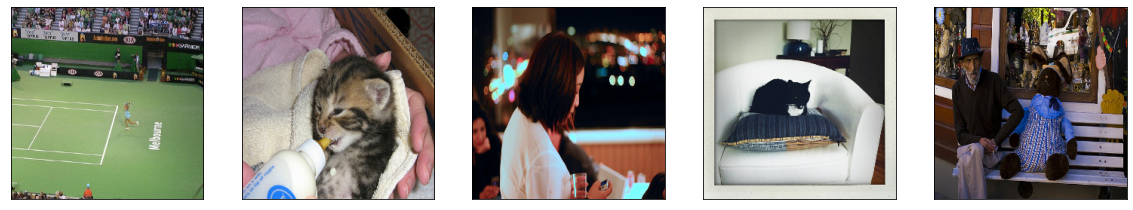

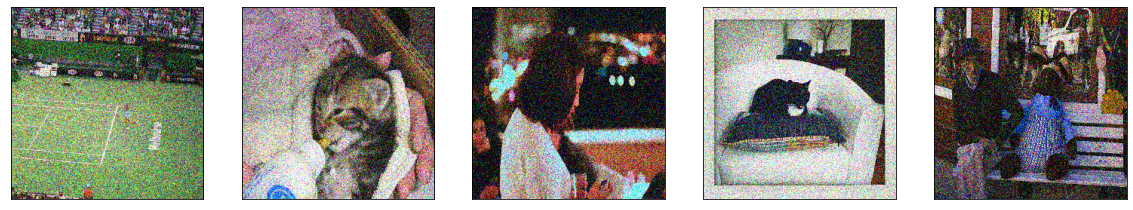

In [6]:
#Affichage d'image
def display_image(X, n, size = 20):
    plt.figure(figsize=(size, size))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(X[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

display_image(x_train,5)
display_image(x_train_noisy, 5)

### Principe de l'auto-encodeur

Les auto-encodeurs sont des algorithmes d’apprentissage non supervisé à base de réseaux de neurones artificiels, qui permettent de construire une nouvelle représentation d’un jeu de données. Généralement, celle-ci est plus compacte, et présente moins de descripteurs, ce qui permet de réduire la dimensionnalité du jeu de données. L’architecture d’un auto-encodeur est constitué de deux parties : l’encodeur et le décodeur.


L’encodeur est constitué par un ensemble de couches de neurones, qui traitent les données afin de construire de nouvelles représentations dites “encodées”. À leur tour, les couches de neurones du décodeur, reçoivent ces représentations et les traitent afin d’essayer de reconstruire les données de départ. Les différences entre les données reconstruites et les données initiales permettent de mesurer l’erreur commise par l’auto-encodeur. L’entraînement consiste à modifier les paramètres de l’auto-encodeur afin de réduire l’erreur de reconstruction mesurée sur les différents exemples du jeu de données.


La plupart du temps, on ne s’intéresse pas à la dernière couche du décodeur, qui contient uniquement la reconstruction des données initiales, mais plutôt à la nouvelle représentation créée par l’encodeur.

L’architecture la plus simple d’un auto-encodeur est semblable à un perceptron multicouches. Cependant, en fonction des données traitées, on peut utiliser différentes topologies de réseaux de neurones. Par exemple, des couches convolutives afin d’analyser des images ou des couches de neurones récurrentes pour traiter des séries temporelles ou des séquences.

À noter qu’à la différence d’un grand nombre de réseaux de neurones, les auto-encodeurs peuvent être entraînés de manière non-supervisée, ce qui permet d’appliquer ces méthodes à des jeux de données non annotés.

La figure suivante schématise un auto-encodeur simple, dont l’encodeur (encoder) traite des images (inputs), afin de les représenter comme des points dans un espace à deux dimensions (encoded representation), puis décode cette représentation (decoder), afin de retrouver les données de départ (output).

![Autoencoder](./photo_livrable/Autoencoder.png)

### Implémentation du modèle

Dans cette partie, nous allons implémenter le modèle d’auto-encodeur décrit précédemment. Nous définissons au préalable les variables utiles au modèle telles que le nombre d'épochs ou la taille du batch.

Nous utilisons un autoencoder convolutif, l’idée derrière les filtres a convolution est qu’ils permettent de trouver des patterns, des formes dans les images. Les CNN permettent en effet de déterminer de manière progressive les différentes formes puis de les assembler pour en trouver d’autres.

<blockquote> Un CNN applique généralement 3 types d’opérations différentes à une image afin d’en extraire les informations pertinentes.

Ces 3 types d’opérations sont les suivantes :
* La convolution
* Le pooling
* La fonction d’activation de type ReLU
</blockquote>

Nous utilisons donc les fonctions de tensorflow correspondantes pour créer notre modèle :

``Conv2D`` : Correspond à une couche de convolution.

``MaxPooling2D`` : Réalise une opération de Max Pooling.

``Conv2DTranspose`` : Correspond à une couche de déconvolution (inverse d'une opération de convolution).

``UpSampling2D`` : Double les dimensions d'une entrée.

Notre modèle d'auto-encodeur convolutif est composé de :
* un encodeur composé de trois couches convolutives
* un décodeur composé de l'inverse des couches de l'encodeur. 

Nous avons testés différents nombres de convolutions mais à partir de trois couches convolutives il n'y a plus d'améliorations lors du débruitage. D'ou notre choix de mettre trois couches convolutives dans notre modèle.

In [7]:
EPOCHS = 1000
BATCH_SIZE = 18

In [8]:
inputs = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), name="input")
# ENCODING
# Convolution 1
conv1 = Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation='relu', name="conv_1_encoder")(inputs)
pooling1 = MaxPooling2D((2, 2), padding="same", name="pooling_1")(conv1)

# Convolution 2
conv2 = Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', name="conv_2_encoder")(pooling1)
pooling2 = MaxPooling2D((2, 2), padding="same", name="pooling_2")(conv2)

# Convolution 3
conv3 = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', name="conv_3_encoder")(pooling2)
encode = MaxPooling2D((2, 2), padding="same", name="pooling_3")(conv3)


In [9]:
# DECODING

# Déconvolution 1
conv4 = Conv2D(32, (3, 3),  activation="relu", padding="same")(encode)
upsamp1 = UpSampling2D((2, 2), name="sampling_1")(conv4)
#x = Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=2, padding='same', activation='relu', name="conv_2_decoder")(encode)

# Déconvolution 2
conv5 = Conv2D(16, (3, 3),  activation="relu", padding="same")(upsamp1)
upsamp2 = UpSampling2D((2, 2), name="sampling_2")(conv5)
#x = Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, padding='same', activation='relu', name="conv_3_decoder")(x)

# Déconvolution 3
conv6 = Conv2D(8, (3, 3),  activation="relu", padding="same")(upsamp2)
upsamp3 = UpSampling2D((2, 2), name="sampling_3")(conv6)
#x = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, padding='same', activation='relu', name="conv_4_decoder")(x)
 
# Output    
decode = Conv2D(3, (3, 3),  padding="same", activation="sigmoid", name="output")(upsamp3)

### Compliation du modèle
Nous donnons au modèle son entrée et sa sortie, ainsi que la configuration de sa fonction d'optimisation et sa fonction de perte.

La fonction d'optimisation a pour rôle d'optimiser la fonction de perte et de parvenir à des poids idéaux.

La fonction de perte calcule l'écart entre la sortie du modèle et le dataset de validation, produisant une valeur que l'entraînement du modèle cherche à réduire.

In [10]:
#Définition de l'autoencoder et compilation du modèle 
autoencoder = Model(inputs, decode, name="autoencoder")
autoencoder.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv_1_encoder (Conv2D)     (None, 256, 256, 8)       224       
                                                                 
 pooling_1 (MaxPooling2D)    (None, 128, 128, 8)       0         
                                                                 
 conv_2_encoder (Conv2D)     (None, 128, 128, 16)      1168      
                                                                 
 pooling_2 (MaxPooling2D)    (None, 64, 64, 16)        0         
                                                                 
 conv_3_encoder (Conv2D)     (None, 64, 64, 32)        4640      
                                                                 
 pooling_3 (MaxPooling2D)    (None, 32, 32, 32)        

In [11]:
callback_bestmodel = tf.keras.callbacks.ModelCheckpoint(filepath='./bestmodel.h5', verbose=0, save_best_only=True)
callbacks_list = [callback_bestmodel]

In [ ]:
#On entraine l'autoencoder
history = autoencoder.fit(x_train_noisy, 
                          x_train, 
                          epochs= EPOCHS,
                          shuffle=True,
                          batch_size = BATCH_SIZE,  
                          validation_data=(x_test_noisy, x_test),
                          callbacks = callbacks_list
                         )

In [ ]:
# On affiche les courbes loss du train et test 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.xlabel("epochs")
plt.ylabel(list(history.history.keys())[0])
plt.show()

## Interpretation des courbes 

Nous voyons sur ce graphique l'évolution de la fonction perte au cours de l'entraînement, démontrant ainsi l'amélioration de notre modèle.

Nous remarquons que sur le jeu de donnée d'entraînement ou de valdiation nos résultats sont semblable. Notre modèle n'est donc pas sur entraîné ou sous entraîné.



## Comparaison des images

Avec le modèle entraîné, nous pouvons maintenant réaliser des prédictions, c'est-à-dire exécuter le processus de denoising par l'auto-encodeur. Nous affichons ainsi des images nettes et les images traitées pour les comparer.

In [ ]:
predictions = autoencoder.predict(x_test_noisy)
display_image(x_test, 5)
display_image(x_test_noisy, 5)
display_image(predictions, 5)

In [ ]:
# On sauvegarde le modèle pour le réutiliser
autoencoder.save('PATH_MODEL_SAVE')
model = tf.keras.models.load_model(PATH_MODEL_SAVE)

## Utilisation sur un autre jeu de donnée
Nous utilisons une image bruitée issue d'un autre jeu de donnée que le notre, afin d'appliquer le traitement de notre modèle.

Le modèle est chargé à partir d'une précédente version sauvegardée afin de ne pas avoir à réaliser l'étape d'entraînement de nouveau.

In [ ]:
# On met l'image de test dans le bon format
input_img = PIL.Image.open('../input/leyenda-a/Dataset/noisy_003.jpg').convert('RGB')
input_img = input_img.resize((256, 256), PIL.Image.ANTIALIAS)
input_img = np.array(input_img, dtype=np.float32)
input_img = input_img.astype('float32')/255
input_img = tf.expand_dims(input_img, axis=0)

# Comparaison des images

Avec le modèle entraîné, nous pouvons maintenant réaliser des prédictions, c'est-à-dire exécuter le processus de denoising par l'auto-encodeur. Nous affichons ainsi des images nettes et les images traitées pour les comparer.

In [ ]:
# Prédire une version débruité
denoised = model.predict(input_img)
display_image(denoised, n=1)

Les images qui sont affichées sont le résultat de notre opération de débruitage et ne nous donne pas un résultat très convainquant. <br/>
Le résultat visuel de notre modèle pouvant être amélioré, nous avons cherché un moyen de le rendre plus performant.

## Amélioration du modèle 

Cette partie a pour but d'augmenter la qualité de nos résultats. Pour cela, nous avons choisi d'implémenter une architecture de DAE (Denoising AutoEncoder)

Dans cette architecture, nous utilisons une fonction d'activation leaky Relu ainsi que la méthode de batch normalization.<br/>

> **Leaky Relu:** Il s'agit d'une fonction d'activation qui se base sur RELU, mais elle a une petite pente pour les valeurs négatives au lieu d'une pente plate. Le coefficient de pente est déterminé avant l'entraînement et ajuster au cours des époques. Comme le montre la représentation ci-dessous.

![Leaky_Relu.PNG](./photo_livrable/leakyrelu.png)

> **Batch Normalization:** Il s'agit d'une méthode utilisée pour rendre le réseau de neurones artificiels plus rapide et plus stable en normalisant les données à l'entrée des couches.

In [ ]:
#Encodeur
def Conv2DLayer(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = Conv2D(filters, kernel_size=kernel, strides=strides, padding=padding,
                      kernel_initializer=kernel_init, name=prefix+'conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

**Conv2DTranspose()** est une opération de convolution dont le noyau est appris lors de l'entraînement de notre modèle. L'utilisation de Conv2DTranspose suréchantillonnera également son entrée, mais la principale différence est que le modèle doit apprendre quel est le meilleur suréchantillonnage pour sa tâche.

In [ ]:
#Décodeur
def Transpose_Conv2D(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = Conv2DTranspose(filters, kernel_size=kernel, strides=strides, padding=padding,
                               kernel_initializer=kernel_init, name=prefix+'de-conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

### Implémentation du modèle

Nous définissons et entraînons notre modèle de la même manière que le précedent. 

In [ ]:
def AutoEncoder(input_shape):
    inputs = Input(shape=input_shape)
    
    conv1 = Conv2DLayer(inputs, 64, 3, strides=1, padding='same', block_id=1)
    conv2 = Conv2DLayer(conv1, 64, 3, strides=2, padding='same', block_id=2)
    
    conv3 = Conv2DLayer(conv2, 128, 5, strides=2, padding='same', block_id=3)
    
    conv4 = Conv2DLayer(conv3, 128, 3, strides=1, padding='same', block_id=4)
    conv5 = Conv2DLayer(conv4, 256, 5, strides=2, padding='same', block_id=5)

    conv6 = Conv2DLayer(conv5, 512, 3, strides=2, padding='same', block_id=6)
    
    deconv1 = Transpose_Conv2D(conv6, 512, 3, strides=2, padding='same', block_id=7)

    skip1 = layers.concatenate([deconv1, conv5], name='skip1')
    conv7 = Conv2DLayer(skip1, 256, 3, strides=1, padding='same', block_id=8)
    deconv2 = Transpose_Conv2D(conv7, 128, 3, strides=2, padding='same', block_id=9)
    
    skip2 = layers.concatenate([deconv2, conv3], name='skip2')
    conv8 = Conv2DLayer(skip2, 128, 5, strides=1, padding='same', block_id=10)
    deconv3 = Transpose_Conv2D(conv8, 64, 3, strides=2, padding='same', block_id=11)
    
    skip3 = layers.concatenate([deconv3, conv2], name='skip3')
    conv9 = Conv2DLayer(skip3, 64, 5, strides=1, padding='same', block_id=12)
    deconv4 = Transpose_Conv2D(conv9, 64, 3, strides=2, padding='same', block_id=13)
    
    skip3 = layers.concatenate([deconv4, conv1])
    conv10 = layers.Conv2D(3, 3, strides=1, padding='same', activation='sigmoid', kernel_initializer=orthogonal(), name='final_conv')(skip3)

    
    return models.Model(inputs=inputs, outputs=conv10)

model = AutoEncoder((IMAGE_HEIGHT, IMAGE_WIDTH, 3))
model_opt = tf.keras.optimizers.Adam(learning_rate=0.002)
model.compile(optimizer=model_opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
callback_bestmodel_improved = tf.keras.callbacks.ModelCheckpoint(filepath=pathlib.Path(r"./new.h5"), verbose=0, save_best_only=True)
callbacks_list_improved = [callback_bestmodel_improved]

In [ ]:
history = model.fit(x_train_noisy, x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks = callbacks_list_improved
)

In [ ]:
# On affiche les courbes loss du train et test 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.xlabel("epochs")
plt.ylabel(list(history.history.keys())[0])
plt.show()

In [ ]:
predictions = model.predict(x_test_noisy)
display_image(x_test, 5)
display_image(x_test_noisy, 5)
display_image(predictions, 5)

## Evaluation des performances de l'autoencodeur

Notre autoencodeur est capable de débruiter toute image, et cela avec un résultat convaincant à l'oeil nu. Evaluons à présent les performances de cet autoencodeur à l'aide d'une métrique.
Pour l'évaluer et savoir si les images générées par ce dernier sont de qualité, nous allons utiliser des méthodes de comparaison d'images. Nous allons implémenter alors le **SSIM**.

> **SSIM** : Structural SIMilarity est une mesure de similarité entre deux images numériques. La SSIM est corrélée à la qualité et à la perception du système visuel humain. Au lieu d'utiliser les méthodes traditionnelles de sommation des erreurs, la SSIM modélise la distorsion de l'image comme une combinaison de trois facteurs qui sont la perte de corrélation, la distorsion de luminance et la distorsion de contraste.

In [ ]:
ssim_noisy = ssim(x_test, x_test_noisy,data_range=x_test_noisy.max() - x_test_noisy.min(), multichannel=True)
ssim_denoised = ssim(x_test, predictions,data_range=predictions.max() - predictions.min(), multichannel=True)

print(f'SSIM entre l\'image originale et celle bruitée :  {ssim_noisy}')
print(f'SSIM entre l\'image originale et celle générée :  {ssim_denoised}')

### Interprétation des résultats

Nous affichons les valeurs de SSIM pour chacune de nos images. Le but étant d'avoir une valeur de SSIM la plus proche de 1 possible.
    
Nous avons une valeur moyenne de **0,96** pour l'image générée et une valeur moyenne de **0,72** pour l'image bruitée. Nous pouvons en conclure que, pour notre modèle, l'image générée est très similaire à l'image d'origine.

## Utilisation sur un autre jeu de donnée

Dans le but d'attester des bonnes performances de notre modèle nous avons décidé de réaliser une étude de cas. Nous importons alors une image qui ne fait pas parti de notre dataset de base, nous la convertissons dans le but de la rendre exploitable pour le modèle puis nous verrons alors le resultat que ça donne sur une autre image.

In [ ]:
# On met l'image de test dans le bon format
input_img = PIL.Image.open('../input/leyenda-a/Dataset/noisy_003.jpg').convert('RGB')
input_img = input_img.resize((256, 256), PIL.Image.ANTIALIAS)
input_img = np.array(input_img, dtype=np.float32)
input_img = input_img.astype('float32')/255
input_img = tf.expand_dims(input_img, axis=0)

In [ ]:
# Prédire une version débruité
denoised = model.predict(input_img)
display_image(denoised, n=1)